In [170]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
# MPC import
import numpy as np
from LinearMPC_3_1.MPCVelControl import MPCVelControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

import matplotlib.pyplot as plt
from control import dlqr
from mpt4py import Polyhedron

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [172]:
Ts = 0.05
sim_time = 7
H = 2
x0 = [0,0,0,0,0,np.deg2rad(40),0,0,0,0,0,0]  # initial state
# x0 = [0,0,0,0,0,0,5,5,5,0,0,0]
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, _ = rocket.simulate_control(
    mpc, sim_time, H, x0, method="linear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1
vis.animate(t_cl[:-1], x_cl[:, :-1], u_cl, T_ol=t_ol[..., :-1], X_ol=x_ol, U_ol=u_ol);

Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=139, step=2), IntSlider(value=0…

In [173]:

from scipy.signal import cont2discrete

# Get the full linearized system
sys = rocket.linearize_sys(mpc.xs, mpc.us)

# --- SUBSYSTEM DEFINITIONS ---
sys_x = sys._parse_subsystem(
    idx=np.array([1, 4, 6]),      # States: wy, beta, vx
    idu=np.array([1]),           # Input: d2
    idy=np.array([6]),           # Output: vx
    name="sys_x"
)

sys_y = sys._parse_subsystem(
    idx=np.array([0, 3, 7]),      # States: wx, alpha, vy
    idu=np.array([0]),           # Input: d1
    idy=np.array([7]),           # Output: vy
    name="sys_y"
)

sys_z = sys._parse_subsystem(
    idx=np.array([8]),           # State: vz
    idu=np.array([2]),           # Input: Pavg
    idy=np.array([8]),           # Output: vz
    name="sys_z"
)

sys_roll = sys._parse_subsystem(
    idx=np.array([2, 5]),         # States: wz, gamma
    idu=np.array([3]),            # Input: Pdiff
    idy=np.array([5]),            # Output: gamma
    name="sys_roll"
)

subsystems = [("x", sys_x), ("y", sys_y), ("z", sys_z), ("roll", sys_roll)]


In [166]:
def max_invariant_set(A_cl, X: Polyhedron, max_iter=60) -> Polyhedron:
    """Compute invariant set for an autonomous linear time invariant system x+ = A_cl x inside a polyhedron X."""
    O = X
    itr = 1
    while itr < max_iter:
        Oprev = O
        F, f = O.A, O.b
        O = Polyhedron.from_Hrep(np.vstack((F, F @ A_cl)), np.hstack((f, f)))
        O.minHrep(True)
        _ = O.Vrep 
        if O == Oprev:
            print(f'Maximum invariant set successfully computed after {itr} iterations.')
            break
        itr += 1
    return O


In [174]:
# Compute terminal invariant sets for ALL subsystems
# Q and R values from LinearMPC_3_1 implementation
subsystem_params = {
    "x": {
        "Q": np.diag([1.0, 5.0, 0.1]),
        "R": np.diag([20.0]),
        "state_names": ['wy', 'beta', 'vx'],
        "state_constraint_idx": 1,  # beta
        "input_max": np.deg2rad(15)
    },
    "y": {
        "Q": np.diag([1.0, 5.0, 0.1]),
        "R": np.diag([20.0]),
        "state_names": ['wx', 'alpha', 'vy'],
        "state_constraint_idx": 1,  # alpha
        "input_max": np.deg2rad(15)
    },
    "z": {
        "Q": np.diag([15.0]),
        "R": np.diag([1.0]),
        "state_names": ['vz'],
        "state_constraint_idx": None,  # No state constraint
        "input_max": None  # Special: 40 <= Pavg <= 80
    },
    "roll": {
        "Q": np.diag([1.0, 10.0]),
        "R": np.diag([0.5]),
        "state_names": ['wz', 'gamma'],
        "state_constraint_idx": 1,  # gamma
        "input_max": 20.0  # Pdiff in %
    }
}

terminal_sets = {}
Ts = 0.05

for subsystem_name, subsystem in subsystems:
    print(f"\n{'='*60}")
    print(f"Computing Terminal Invariant Set for Subsystem: {subsystem_name.upper()}")
    print(f"{'='*60}")
    
    params = subsystem_params[subsystem_name]
    Ac = subsystem.A
    Bc = subsystem.B
    
    Ad, Bd, _, _, _ = cont2discrete((Ac, Bc, subsystem.C, subsystem.D), Ts)
    A, B = Ad, Bd
    Q, R = params["Q"], params["R"]
    
    # State constraints
    nx = A.shape[0]
    if params["state_constraint_idx"] is not None:
        F_x = np.zeros((2, nx))
        F_x[0, params["state_constraint_idx"]] = 1
        F_x[1, params["state_constraint_idx"]] = -1
        f_x = np.array([np.deg2rad(10), np.deg2rad(10)])
    else:
        F_x = np.vstack([np.eye(nx), -np.eye(nx)])
        f_x = np.hstack([100.0 * np.ones(nx), 100.0 * np.ones(nx)])
    X = Polyhedron.from_Hrep(F_x, f_x)
    
    # Input constraints
    if subsystem_name == "z":
        xs, us = rocket.trim()
        F_u = np.array([[1], [-1]])
        f_u = np.array([80.0 - us[2], -(40.0 - us[2])])
    else:
        F_u = np.array([[1], [-1]])
        f_u = np.array([params["input_max"], params["input_max"]])
    U = Polyhedron.from_Hrep(F_u, f_u)
    
    # Compute LQR terminal controller
    K, Qf, _ = dlqr(A, B, Q, R)
    K = -K
    
    print(f'Q: {np.diag(Q)}, R: {np.diag(R)}')
    print(f'Terminal weight Qf:\n{Qf}')
    print(f'Terminal controller K:\n{K}')
    
    # Compute maximal invariant set
    A_cl = A + B @ K
    KU = Polyhedron.from_Hrep(U.A @ K, U.b)
    X_intersect = X.intersect(KU)
    O_inf = max_invariant_set(A_cl, X_intersect)
    
    terminal_sets[subsystem_name] = {
        'Xf': O_inf,
        'Q': Q,
        'R': R,
        'Qf': Qf,
        'K': K,
        'A': A,
        'B': B,
        'dim': O_inf.dim,
        'state_names': params["state_names"]
    }
    
    print(f'Terminal invariant set dimension: {O_inf.dim}')

print(f"\n{'='*60}")
print("All terminal invariant sets computed!")
print(f"{'='*60}")



Computing Terminal Invariant Set for Subsystem: X
Q: [1.  5.  0.1], R: [20.]
Terminal weight Qf:
[[ 2.49262873  6.47590462  0.81275509]
 [ 6.47590462 87.08640095  8.12579956]
 [ 0.81275509  8.12579956  2.37315336]]
Terminal controller K:
[[0.19844241 0.53034052 0.04557924]]
Maximum invariant set successfully computed after 18 iterations.
Terminal invariant set dimension: 3

Computing Terminal Invariant Set for Subsystem: Y
Q: [1.  5.  0.1], R: [20.]
Terminal weight Qf:
[[ 2.49262873  6.47590462 -0.81275509]
 [ 6.47590462 87.08640095 -8.12579956]
 [-0.81275509 -8.12579956  2.37315336]]
Terminal controller K:
[[ 0.19844241  0.53034052 -0.04557924]]
Maximum invariant set successfully computed after 18 iterations.
Terminal invariant set dimension: 3

Computing Terminal Invariant Set for Subsystem: Z
Q: [15.], R: [1.]
Terminal weight Qf:
[[534.16749742]]
Terminal controller K:
[[-3.81821736]]
Maximum invariant set successfully computed after 1 iterations.
Terminal invariant set dimension: 


X subsystem - Dimension: 3


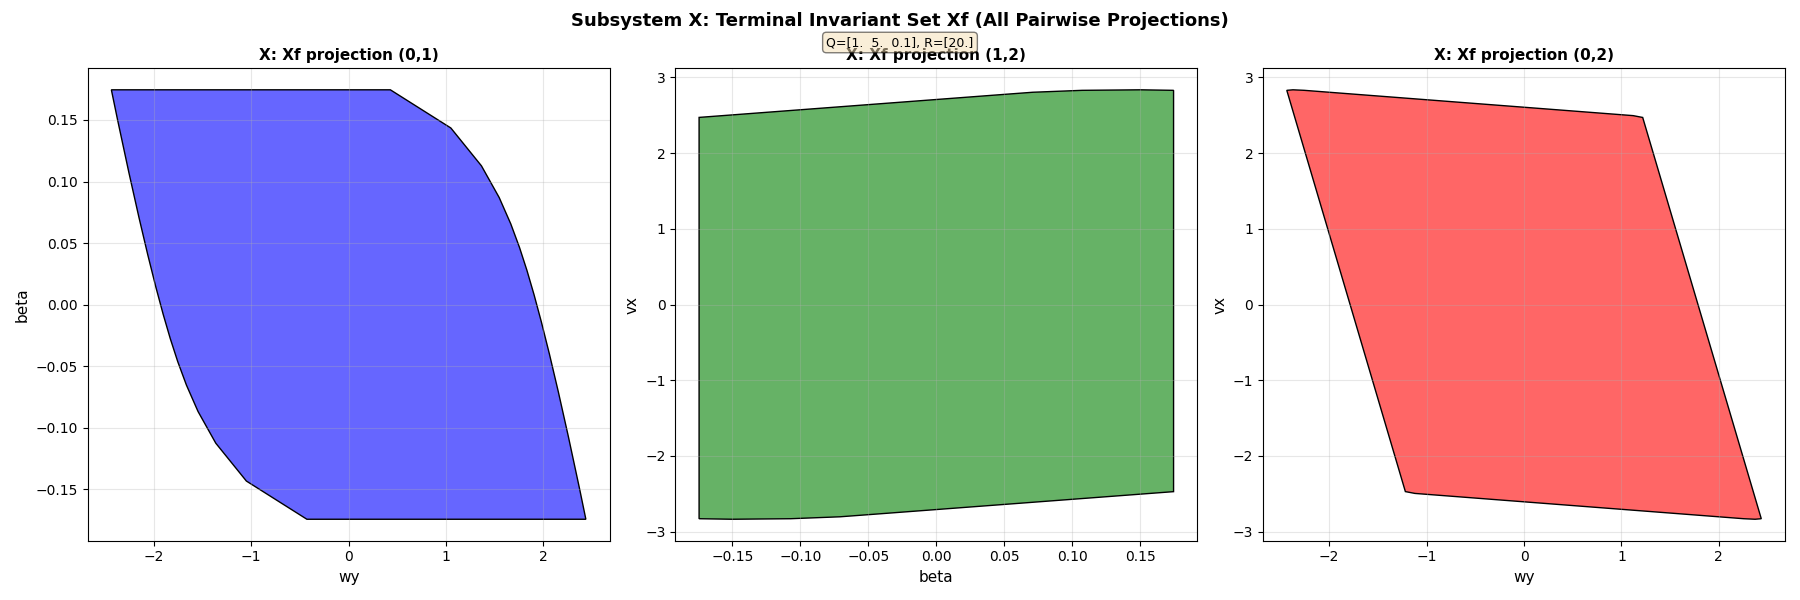


Y subsystem - Dimension: 3


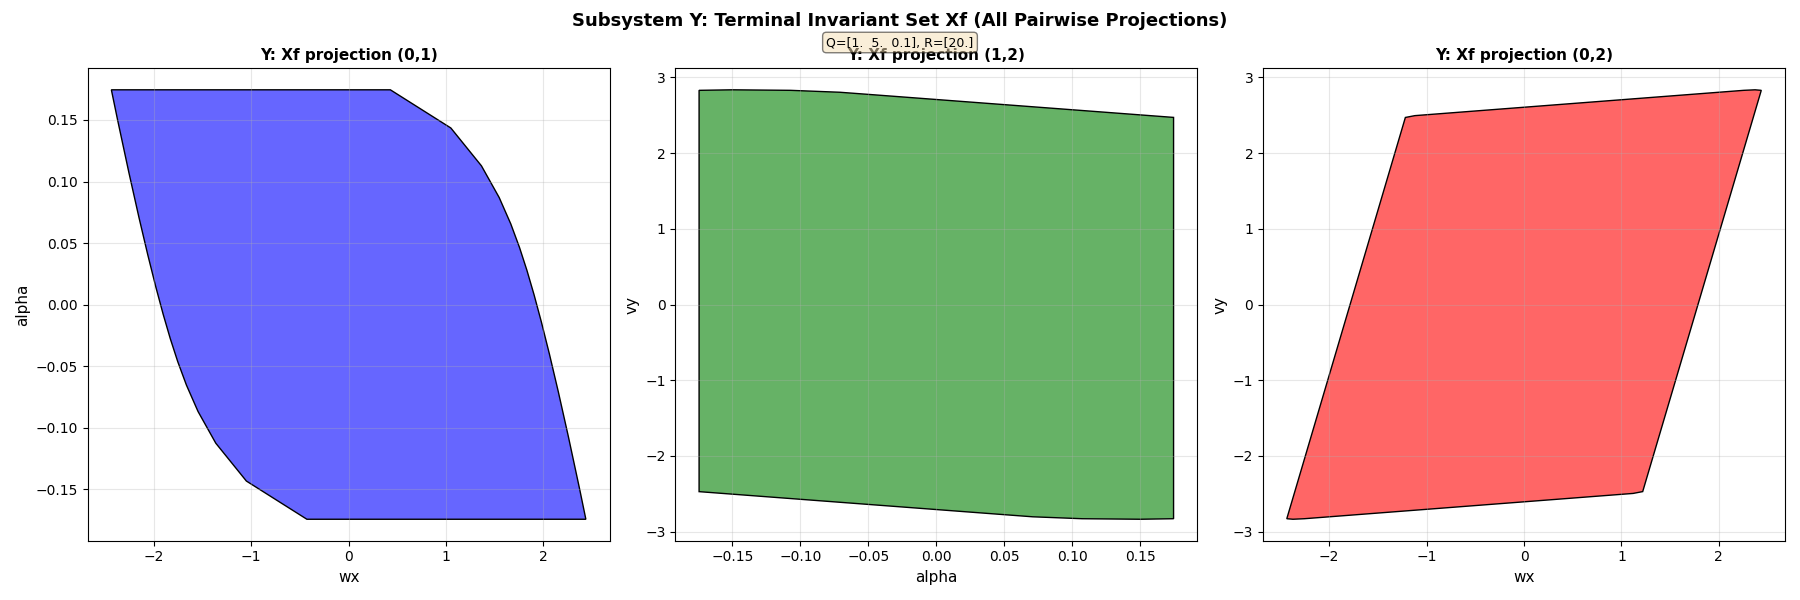


Z subsystem - Dimension: 1


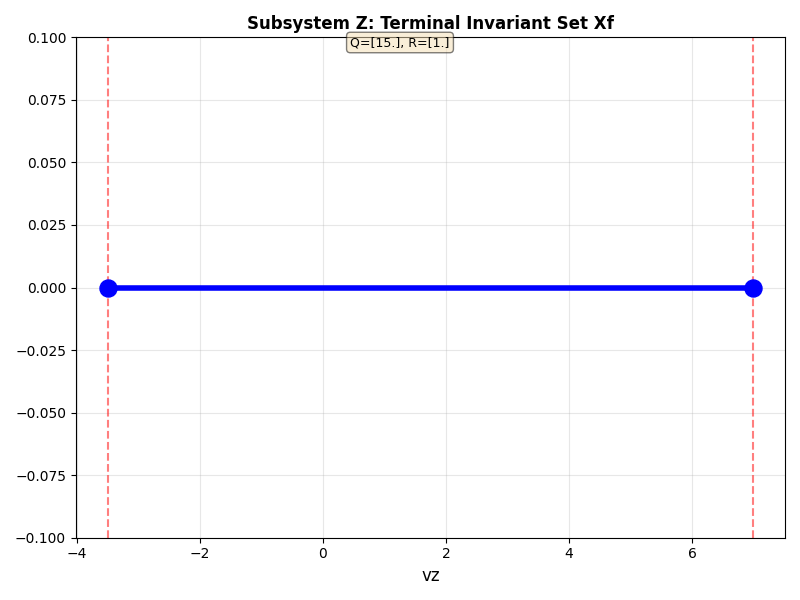


ROLL subsystem - Dimension: 2


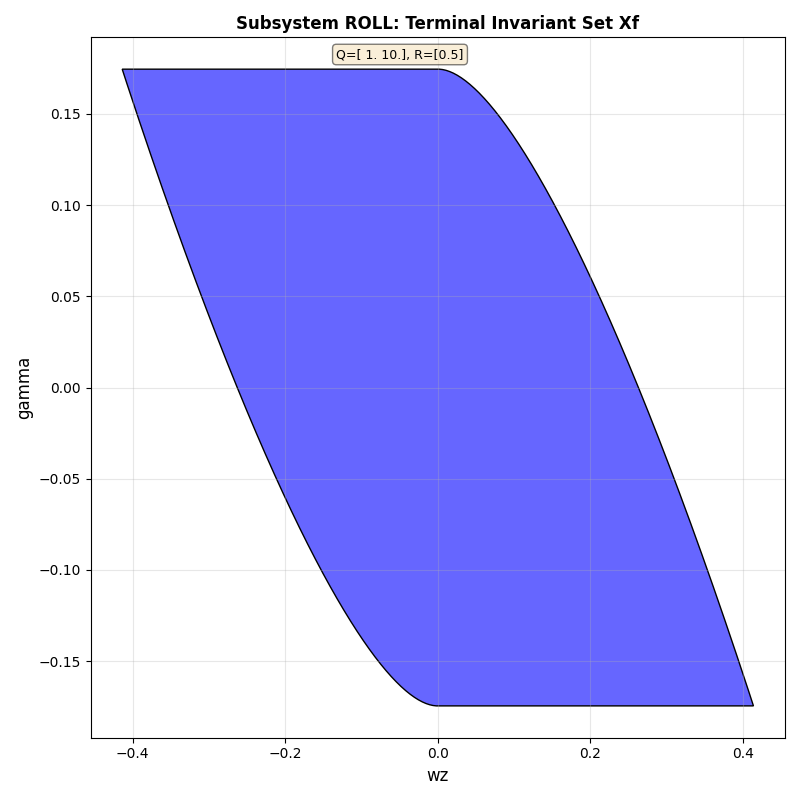


TERMINAL INVARIANT SET SUMMARY

X subsystem:
  Dimension: 3
  Q (state weights): [1.  5.  0.1]
  R (input weight): [20.]
  Terminal controller K:
[[0.19844241 0.53034052 0.04557924]]

Y subsystem:
  Dimension: 3
  Q (state weights): [1.  5.  0.1]
  R (input weight): [20.]
  Terminal controller K:
[[ 0.19844241  0.53034052 -0.04557924]]

Z subsystem:
  Dimension: 1
  Q (state weights): [15.]
  R (input weight): [1.]
  Terminal controller K:
[[-3.81821736]]

ROLL subsystem:
  Dimension: 2
  Q (state weights): [ 1. 10.]
  R (input weight): [0.5]
  Terminal controller K:
[[-9.26472734 -4.36438034]]


In [175]:
# Plot terminal invariant sets for ALL subsystems
for subsystem_name, data in terminal_sets.items():
    Xf = data['Xf']
    dim = data['dim']
    state_names = data['state_names']
    
    print(f"\n{subsystem_name.upper()} subsystem - Dimension: {dim}")

    if dim == 1:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        try:
            vrep = Xf.Vrep
            if hasattr(vrep, 'V') and vrep.V is not None:
                vertices = vrep.V
                if len(vertices) >= 2:
                    x_min = np.min(vertices[:, 0])
                    x_max = np.max(vertices[:, 0])
                    ax.plot([x_min, x_max], [0, 0], 'b-', linewidth=4, label='Xf (Terminal Set)')
                    ax.scatter([x_min, x_max], [0, 0], s=150, c='b', zorder=5, marker='o')
                    ax.axvline(x_min, color='r', linestyle='--', alpha=0.5, label='Bounds')
                    ax.axvline(x_max, color='r', linestyle='--', alpha=0.5)
        except Exception as e:
            try:
                bounds = Xf.bounding_box()
                if bounds is not None:
                    x_min, x_max = bounds[0][0], bounds[1][0]
                    ax.plot([x_min, x_max], [0, 0], 'b-', linewidth=4, label='Xf')
                    ax.scatter([x_min, x_max], [0, 0], s=150, c='b', zorder=5)
            except:
                print("Cannot determine 1D bounds.")
        
        ax.set_xlabel(f'{state_names[0]}', fontsize=12)
        ax.set_title(f'Subsystem {subsystem_name.upper()}: Terminal Invariant Set Xf', fontsize=12, fontweight='bold')
        fig.text(0.5, 0.94, f'Q={np.diag(data["Q"])}, R={np.diag(data["R"])}',
                ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.1, 0.1)
        
    elif dim == 2:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        Xf.plot(ax, color='blue', opacity=0.6, show_vertices=False)
        ax.set_xlabel(f'{state_names[0]}', fontsize=12)
        ax.set_ylabel(f'{state_names[1]}', fontsize=12)
        ax.set_title(f'Subsystem {subsystem_name.upper()}: Terminal Invariant Set Xf', fontsize=12, fontweight='bold')
        fig.text(0.5, 0.94, f'Q={np.diag(data["Q"])}, R={np.diag(data["R"])}',
                ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.grid(True, alpha=0.3)
        ax.set_aspect('auto')
        
    elif dim == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        proj_01 = Xf.projection(dims=(0, 1))
        proj_01.plot(axes[0], color='blue', opacity=0.6, show_vertices=False)
        axes[0].set_xlabel(f'{state_names[0]}', fontsize=11)
        axes[0].set_ylabel(f'{state_names[1]}', fontsize=11)
        axes[0].set_title(f'{subsystem_name.upper()}: Xf projection (0,1)', fontsize=11, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_aspect('auto')
        
        proj_12 = Xf.projection(dims=(1, 2))
        proj_12.plot(axes[1], color='green', opacity=0.6, show_vertices=False)
        axes[1].set_xlabel(f'{state_names[1]}', fontsize=11)
        axes[1].set_ylabel(f'{state_names[2]}', fontsize=11)
        axes[1].set_title(f'{subsystem_name.upper()}: Xf projection (1,2)', fontsize=11, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_aspect('auto')
        
        proj_02 = Xf.projection(dims=(0, 2))
        proj_02.plot(axes[2], color='red', opacity=0.6, show_vertices=False)
        axes[2].set_xlabel(f'{state_names[0]}', fontsize=11)
        axes[2].set_ylabel(f'{state_names[2]}', fontsize=11)
        axes[2].set_title(f'{subsystem_name.upper()}: Xf projection (0,2)', fontsize=11, fontweight='bold')
        axes[2].grid(True, alpha=0.3)
        axes[2].set_aspect('auto')
        
        fig.suptitle(f'Subsystem {subsystem_name.upper()}: Terminal Invariant Set Xf (All Pairwise Projections)',
                    fontsize=13, fontweight='bold', y=0.98)
        fig.text(0.5, 0.94, f'Q={np.diag(data["Q"])}, R={np.diag(data["R"])}',
                ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Print summary
print("\n" + "="*70)
print("TERMINAL INVARIANT SET SUMMARY")
print("="*70)
for subsystem_name, data in terminal_sets.items():
    print(f"\n{subsystem_name.upper()} subsystem:")
    print(f"  Dimension: {data['dim']}")
    print(f"  Q (state weights): {np.diag(data['Q'])}")
    print(f"  R (input weight): {np.diag(data['R'])}")
    print(f"  Terminal controller K:\n{data['K']}")


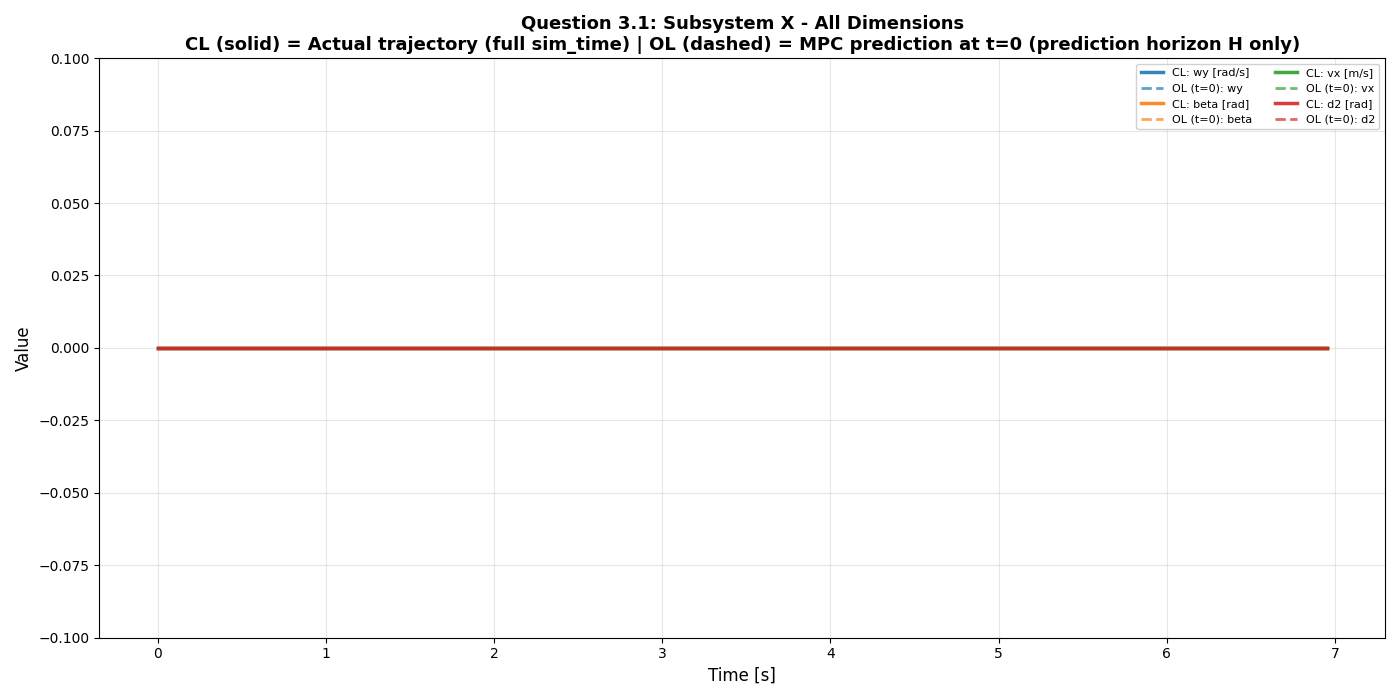

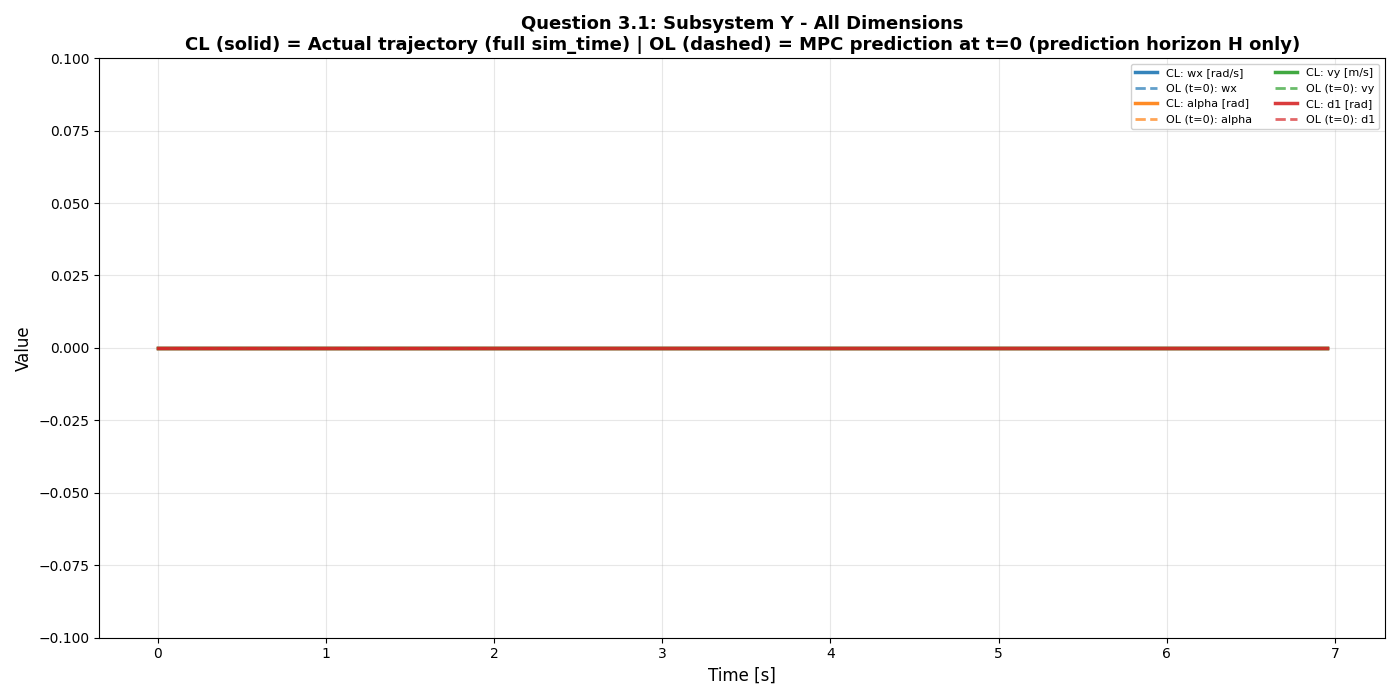

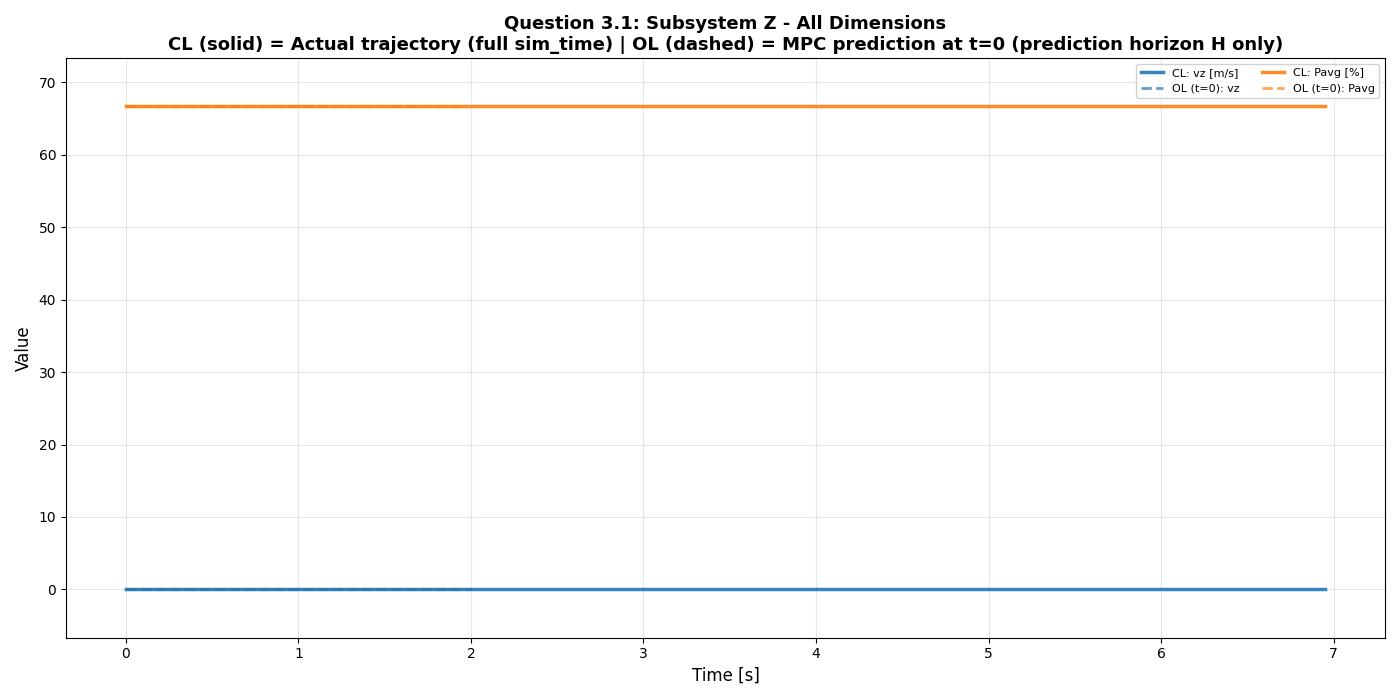

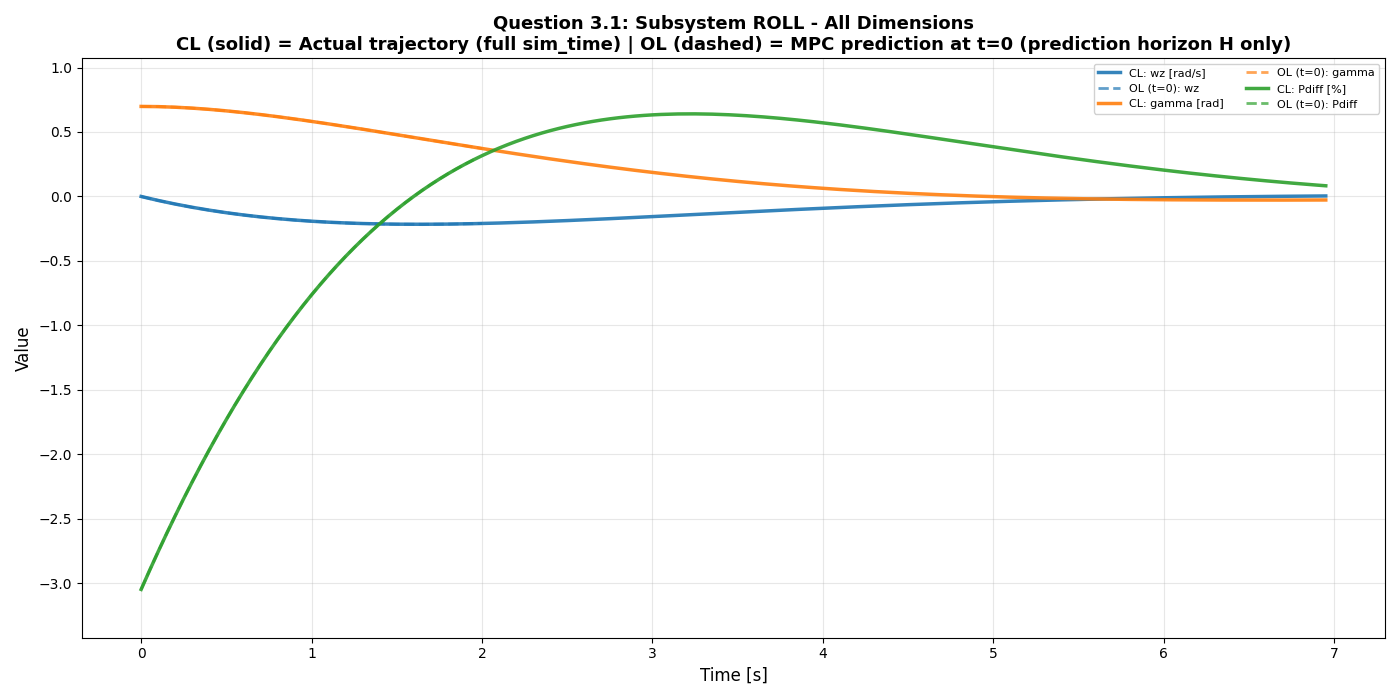

In [176]:
# Question 3.1: Plot Open Loop (OL) vs Closed Loop (CL) trajectories for each subsystem
# Uses the simulation data from cell 2 (works for any initial condition)

# Get subsystem definitions (already defined in cell 3)
# Use the existing sys object from cell 3
subsystems_info = [
    {
        'name': 'x',
        'state_indices': [1, 4, 6],  # wy, beta, vx
        'state_names': ['wy', 'beta', 'vx'],
        'state_units': ['rad/s', 'rad', 'm/s'],
        'input_index': 1,  # d2
        'input_name': 'd2',
        'input_unit': 'rad'
    },
    {
        'name': 'y',
        'state_indices': [0, 3, 7],  # wx, alpha, vy
        'state_names': ['wx', 'alpha', 'vy'],
        'state_units': ['rad/s', 'rad', 'm/s'],
        'input_index': 0,  # d1
        'input_name': 'd1',
        'input_unit': 'rad'
    },
    {
        'name': 'z',
        'state_indices': [8],  # vz
        'state_names': ['vz'],
        'state_units': ['m/s'],
        'input_index': 2,  # Pavg
        'input_name': 'Pavg',
        'input_unit': '%'
    },
    {
        'name': 'roll',
        'state_indices': [2, 5],  # wz, gamma
        'state_names': ['wz', 'gamma'],
        'state_units': ['rad/s', 'rad'],
        'input_index': 3,  # Pdiff
        'input_name': 'Pdiff',
        'input_unit': '%'
    }
]

# Question 3.1: Plot Open Loop (OL) vs Closed Loop (CL) trajectories for each subsystem
# All dimensions (states + input) on the same plot for each subsystem

colors_states = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each dimension

# Only show OL prediction at t=0
ol_time_index = 0  # Only at initial time

for sub_info in subsystems_info:
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    
    # Plot all states on the same axes
    for idx, (state_idx, state_name, state_unit) in enumerate(zip(sub_info['state_indices'], 
                                                                    sub_info['state_names'], 
                                                                    sub_info['state_units'])):
        color = colors_states[idx % len(colors_states)]
        
        # Get the actual data being plotted
        cl_data = x_cl[state_idx, :-1]
        
        # Closed loop trajectory (actual trajectory) - goes for full sim_time
        ax.plot(t_cl[:-1], cl_data, color=color, linestyle='-', 
               linewidth=2.5, label=f'CL: {state_name} [{state_unit}]', alpha=0.9)
        
        # Open loop trajectory at t=0 only (MPC prediction from initial time)
        if t_ol.ndim == 2 and x_ol.ndim == 3:
            k = ol_time_index
            if k < t_ol.shape[1] and k < x_ol.shape[2]:
                ol_data = x_ol[state_idx, :, k]
                ax.plot(t_ol[:, k], ol_data, color=color, linestyle='--', 
                       linewidth=2, label=f'OL (t=0): {state_name}', alpha=0.7)
    
    # Plot input on the same axes
    input_idx = sub_info['input_index']
    input_color = colors_states[len(sub_info['state_indices']) % len(colors_states)]
    
    # Get the actual input data being plotted
    u_data = u_cl[input_idx, :]
    
    # Closed loop trajectory for input (actual input applied) - goes for full sim_time
    ax.plot(t_cl[:-1], u_data, color=input_color, linestyle='-', 
           linewidth=2.5, label=f'CL: {sub_info["input_name"]} [{sub_info["input_unit"]}]', alpha=0.9)
    
    # Open loop trajectory for input at t=0 only (predicted input from initial time)
    if t_ol.ndim == 2 and u_ol.ndim == 3:
        k = ol_time_index
        if k < t_ol.shape[1] and k < u_ol.shape[2]:
            t_ol_input = t_ol[:u_ol.shape[1], k]
            u_ol_data = u_ol[input_idx, :, k]
            ax.plot(t_ol_input, u_ol_data, color=input_color, linestyle='--', 
                   linewidth=2, label=f'OL (t=0): {sub_info["input_name"]}', alpha=0.7)
    
    # Set y-axis limits to show all data clearly (with some padding)
    all_plotted_data = []
    for state_idx in sub_info['state_indices']:
        all_plotted_data.extend(x_cl[state_idx, :-1])
    all_plotted_data.extend(u_cl[sub_info['input_index'], :])
    
    if len(all_plotted_data) > 0:
        y_min, y_max = np.min(all_plotted_data), np.max(all_plotted_data)
        y_range = y_max - y_min
        if y_range > 1e-10:  # Only set limits if there's actual variation
            ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        else:
            # If all values are essentially the same, set a small range around that value
            center = np.mean(all_plotted_data)
            ax.set_ylim(center - 0.1, center + 0.1)
    
    ax.set_xlabel('Time [s]', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'Question 3.1: Subsystem {sub_info["name"].upper()} - All Dimensions\n'
                 f'CL (solid) = Actual trajectory (full sim_time) | OL (dashed) = MPC prediction at t=0 (prediction horizon H only)', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8, ncol=2, framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
